In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import chi2
from scipy.linalg import sqrtm
from numpy.linalg import det
import numpy.linalg as LA
import matplotlib.pyplot as plt
import math

def generate_covariance(true_mu, dims):
    S = np.tril(np.random.randn(dims, dims))
    cov = np.dot(S, S.T)
    while(np.linalg.det(cov) < 0.5):
        cov = cov * 2
    mu = np.random.multivariate_normal(true_mu, cov, 1)[0]

    return mu, cov

def get(dims):
    true_mu = np.zeros((dims, ))

    x_ac, C_ac = generate_covariance(true_mu, dims)
    x_c, C_c = generate_covariance(true_mu, dims)
    x_bc, C_bc = generate_covariance(true_mu, dims)

    C_a = LA.inv(LA.inv(C_ac) + LA.inv(C_c))
    C_b = LA.inv(LA.inv(C_bc) + LA.inv(C_c))

    x_a = C_a @ (LA.inv(C_ac) @ x_ac + LA.inv(C_c) @ x_c)
    x_b = C_b @ (LA.inv(C_bc) @ x_bc + LA.inv(C_c) @ x_c)

    C_fus = LA.inv(LA.inv(C_a) + LA.inv(C_b) - LA.inv(C_c))

    return x_a.reshape(1, dims), x_b.reshape(1, dims), C_a, C_b, C_fus


In [2]:
def plot_ellipse(covariance, ax, label_t="", linestyle='', alpha_val=0.25, color_def='red', center = [0, 0]):
    if covariance.shape[0] == 2:
        x_el = np.array([np.sin(np.linspace(0, 2*math.pi, num=63)), np.cos(np.linspace(0, 2*math.pi, num=63))])
        C = np.linalg.cholesky(covariance)
        y_el = np.dot(C, x_el)
        if len(linestyle) > 0:
            if len(label_t) > 0:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], label=label_t, alpha=alpha_val, color=color_def, linestyle=linestyle)
            else:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], alpha=alpha_val, color=color_def, linestyle=linestyle)            
        else:
            if len(label_t) > 0:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], label=label_t, alpha=alpha_val, color=color_def)
            else:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], alpha=alpha_val, color=color_def)            

def mutual_covariance(cov_a, cov_b):
    D_a, S_a = np.linalg.eigh(cov_a)
    D_a_sqrt = sqrtm(np.diag(D_a))
    D_a_sqrt_inv = inv(D_a_sqrt)
    M = np.dot(np.dot(np.dot(np.dot(D_a_sqrt_inv, inv(S_a)), cov_b), S_a), D_a_sqrt_inv)    # eqn. 10 in Sijs et al.
    D_b, S_b = np.linalg.eigh(M)
    D_gamma = np.diag(np.clip(D_b, a_min=1.0, a_max=None))   # eqn. 11b in Sijs et al.
    return np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(S_a, D_a_sqrt), S_b), D_gamma), inv(S_b)), D_a_sqrt), inv(S_a))  # eqn. 11a in Sijs et al

In [3]:
x_a, x_b, C_a, C_b, C_fus = get(2)

x_a = x_a.reshape(1, 2)
x_b = x_b.reshape(1, 2)

def get_critical_value(dimensions, alpha):
    return chi2.ppf((1 - alpha), df=dimensions)

eta = get_critical_value(2, 0.05)

def inv(mat):
    return np.linalg.inv(mat)

In [40]:
def objective(S):
    return -(S[0]*S[3])

def constraint1(S):
    S = S.reshape(2, 2).T
    A = inv(C_a) - S@S.T
    return np.linalg.eig(A)[0][0]
def constraint2(S):
    S = S.reshape(2, 2).T
    A = inv(C_a) - S@S.T
    return np.linalg.eig(A)[0][1]
def constraint3(S):
    S = S.reshape(2, 2).T
    A = inv(C_b) - S@S.T
    return np.linalg.eig(A)[0][0]
def constraint4(S):
    S = S.reshape(2, 2).T
    A = inv(C_b) - S@S.T
    return np.linalg.eig(A)[0][1]
    


def prob_constraint(S):
    S = S.reshape(2, 2).T
    C_c_inv = S@S.T
    C_ac = inv(inv(C_a) - C_c_inv)
    C_bc = inv(inv(C_b) - C_c_inv)
    x_c = (inv(inv(C_ac) + inv(C_bc)) @ (inv(C_ac) @ x_a.T + inv(C_bc) @ x_b.T)).T
    x_ac = (C_ac @ (inv(C_a) @ x_a.T - C_c_inv @ x_c.T)).T
    x_bc =(C_bc @ (inv(C_b) @ x_b.T - C_c_inv @ x_c.T)).T
    f = ((x_ac - x_bc) @ inv(C_ac + C_bc) @ (x_ac - x_bc).T)[0][0]
    return eta - f

def constraint5(S):
    return 1e-30 - abs(S[2])

b = (-np.inf, np.inf)
bnds = (b, b, b, b)

In [41]:
con1 = {'type': 'ineq', 'fun': constraint1}
con2 = {'type': 'ineq', 'fun': constraint2}
con3 = {'type': 'ineq', 'fun': constraint3}
con4 = {'type': 'ineq', 'fun': constraint4}
con5 = {'type': 'ineq', 'fun': prob_constraint}
con6 = {'type': 'ineq', 'fun': constraint5}
cons = [con1, con2, con3, con4, con5, con6]


In [42]:
S_0 = (np.linalg.cholesky(inv(mutual_covariance(C_a, C_b))).T).reshape(4, )
print(S_0)


[ 2.29999868 -0.76898796  0.          0.65028321]


In [38]:
print('Before optimization, we have...')
print ('objective is',objective(S_0))
print ('constraint1 is ',constraint1(S_0))
print ('constraint2 is ',constraint2(S_0))
print ('constraint3 is ',constraint3(S_0))
print ('constraint4 is ',constraint4(S_0))
print ('constraint5 is ',constraint5(S_0))
print ('prob_constraint is ',prob_constraint(S_0))


Before optimization, we have...
objective is -1.4956505169718504
C_a - C_c_inv is
 [[ 2.75870428 -0.93992544]
 [-0.93992544  0.32024449]]
eig vals are [ 3.07894877e+00 -4.44089210e-16]
constraint1 is  3.0789487698197195
constraint2 is  -4.440892098500626e-16
constraint3 is  -8.881784197001252e-16
constraint4 is  2.4278492217943373
constraint5 is  1e-30
prob_constraint is  231327649430399.3


In [39]:
sol = minimize(objective, S_0, method='COBYLA', constraints=cons)

C_a - C_c_inv is
 [[ 2.75870428 -0.93992544]
 [-0.93992544  0.32024449]]
eig vals are [ 3.07894877e+00 -4.44089210e-16]
C_a - C_c_inv is
 [[ 2.75870428 -0.93992544]
 [-0.93992544  0.32024449]]
eig vals are [ 3.07894877e+00 -4.44089210e-16]
C_a - C_c_inv is
 [[-2.84129308 -0.17093748]
 [-0.17093748  0.32024449]]
eig vals are [-2.85050844  0.32945984]
C_a - C_c_inv is
 [[-2.84129308 -3.47093616]
 [-3.47093616  0.85822041]]
eig vals are [-4.92460102  2.94152836]
C_a - C_c_inv is
 [[-3.84129308 -0.82122068]
 [-0.82122068  0.32024449]]
eig vals are [-3.997487    0.47643841]
C_a - C_c_inv is
 [[-2.84129308 -0.17093748]
 [-0.17093748 -1.98032193]]
eig vals are [-2.87398938 -1.94762562]
C_a - C_c_inv is
 [[ 2.20047098 -1.4055507 ]
 [-1.4055507  -0.61645883]]
eig vals are [ 2.78181666 -1.19780451]
C_a - C_c_inv is
 [[-3.3252093   0.40494289]
 [ 0.40494289 -0.84217336]]
eig vals are [-3.38958015 -0.77780251]
C_a - C_c_inv is
 [[-0.63106841  0.38464288]
 [ 0.38464288 -0.70225877]]
eig vals are [-

In [19]:
print(sol)

     fun: 0.00473307873304127
   maxcv: 1.0030131023736784
 message: 'Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.'
    nfev: 193
  status: 4
 success: False
       x: array([ 2.37766192e+00, -1.63438968e-01,  4.09778429e-02, -1.99064413e-03])


In [22]:
S = sol.x.reshape(2,2)

objective is 0.00473307873304127
constraint1 is  4.704494921577322
constraint2 is  -1.0030131023736784
constraint3 is  -1.003013088686859
constraint4 is  4.053395359865119
constraint5 is  -0.04097784285357384
prob_constraint is  -1.0030127031947895


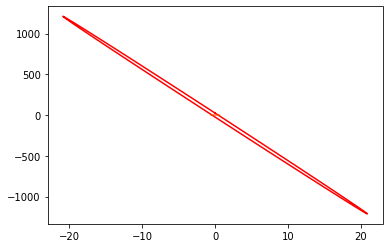

[[ 2.37766192e+00 -1.63438968e-01]
 [ 4.09778429e-02 -1.99064413e-03]]


<Figure size 432x288 with 0 Axes>

In [23]:
S = sol.x
S = S.reshape(2, 2)

C_c = inv(S.T) @ inv(S)

print ('objective is',objective(sol.x))
print ('constraint1 is ',constraint1(sol.x))
print ('constraint2 is ',constraint2(sol.x))
print ('constraint3 is ',constraint3(sol.x))
print ('constraint4 is ',constraint4(sol.x))
print ('constraint5 is ',constraint5(sol.x))
print ('prob_constraint is ',prob_constraint(sol.x))

ax = plt.axes()
plot_ellipse(C_c, ax, alpha_val=1)
plot_ellipse(C_a, ax)
plot_ellipse(C_b, ax)
plot_ellipse(mutual_covariance(C_a, C_b), ax, color_def='orange')
plt.show()
plt.cla()
plt.clf()

print(S)

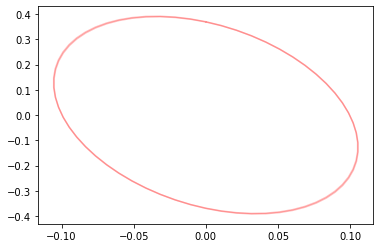

In [26]:
ax = plt.axes()
fus_PC = inv(inv(C_a) + inv(C_b) - inv(C_c))
fus_EI = inv(inv(C_a) + inv(C_b) - inv(mutual_covariance(C_a, C_b)))
plot_ellipse(fus_PC, ax)
plot_ellipse(fus_EI, ax)
plt.show()